<h1 style="margin-bottom: 5px;">Proyecto final - Brain Tumor MRI Challenge</h1>
<h2 style="margin-bottom: 10px;">Introducción a Los Sistemas Inteligentes – 2025-1</h2>

<p>
Fabian Leandro Lopez Gomez - flopezgo@unal.edu.co<br>
Gabriel Alejandro Londono Tobon - glondonot@unal.edu.co<br>
Haider Andres Mayorga Vela - hmayorgav@unal.edu.co
</p>

# A. Descripción del problema

El diagnóstico por resonancia magnética (MRI) del cerebro es rutinario, pero
interpretar cientos de cortes por paciente exige tiempo y especialistas.
Automatizar la **clasificación de tumores cerebrales (glioma, meningioma, pituitario) + ausencia de tumor**  reduce carga clínica y puede acelerar decisiones terapéuticas en zonas con pocos neurorradiólogos

Un error de clasificación (falso positivo o negativo) tiene consecuencias
críticas, por eso la competencia evalúa una **métrica compuesta**:

$$ \text{Score final} = \text{Recall_macro} + \text{Accuracy} $$

* **Recall macro** – promedia la sensibilidad de cada clase, forzando un balance
  en datasets desbalanceados.  
* **Accuracy** – porcentaje global de aciertos

Nuestro objetivo es entrenar, afinar y explicar un clasificador profundo que
maximize dicha métrica, compararlo luego con un LLM multimodal y generar un
`submissionModel.csv` para Kaggle.




---

# B. Importación de datos

In [ ]:
# # ⬇️ 1) Instalación de dependencias (solo la 1.ª vez)
# !pip -q install kaggle albumentations==1.4.6 timm==0.9.12 torchmetrics==1.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.4 MB/s eta 0:00:00
Reason for being yanked: <none given>
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━

In [1]:
# # 1. Sube el archivo kaggle.json
# from google.colab import files


In [ ]:
# files.upload()  # selecciona el archivo kaggle.json

In [ ]:
# # 2. Mueve el archivo al directorio correcto
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/

# # 3. Cambia los permisos para mayor seguridad
# !chmod 600 ~/.kaggle/kaggle.json

# # 4. Descarga la competencia
# !kaggle competitions download -c proyecto-final-iis-2025-1-unal


In [ ]:
# !unzip proyecto-final-iis-2025-1-unal.zip -d ./proyecto-final/

Streaming output truncated to the last 5000 lines.
  inflating: ./proyecto-final/ISI_dataset/train/img0720.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0721.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0722.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0723.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0724.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0725.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0726.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0727.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0728.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0729.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0730.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0731.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0732.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0733.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0734.jpg  
  inflating: ./proy

In [1]:
# # ⬇️ 4) Descargar y descomprimir la competencia
# COMP_TAG = 't-2c8c60c70ec72653cd44d53217feaadd'  # TOKEN de enlace privado
# !kaggle competitions download -c $COMP_TAG -p data
# !unzip -q data/*.zip -d data
from google.colab import drive
drive.mount('/content/drive')
# ⬇️ 5) Cargar CSV de etiquetas
import pandas as pd
labels_df = pd.read_csv('/content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train_labels.csv')
labels_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


id       label
0  img0001.jpg  meningioma
1  img0002.jpg      glioma
2  img0003.jpg   pituitary
3  img0004.jpg      glioma
4  img0005.jpg   pituitary

# C. Exploración de datos

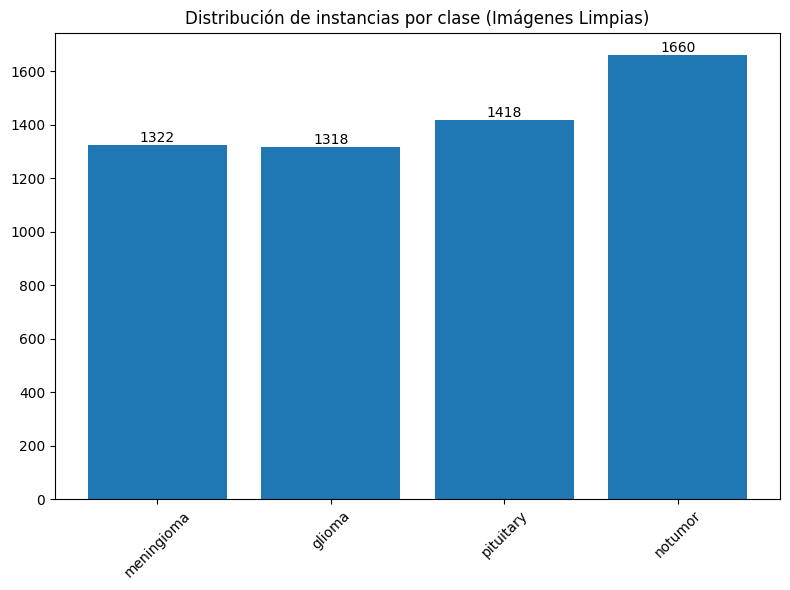

Tamaño medio (W×H): 446.6 × 448.9
Tamaño mínimo (W×H): 150 × 168
Tamaño máximo (W×H): 1920 × 1080
Desviación estándar (W×H): 133.7 × 125.3
Rango (W×H): 1770 × 912


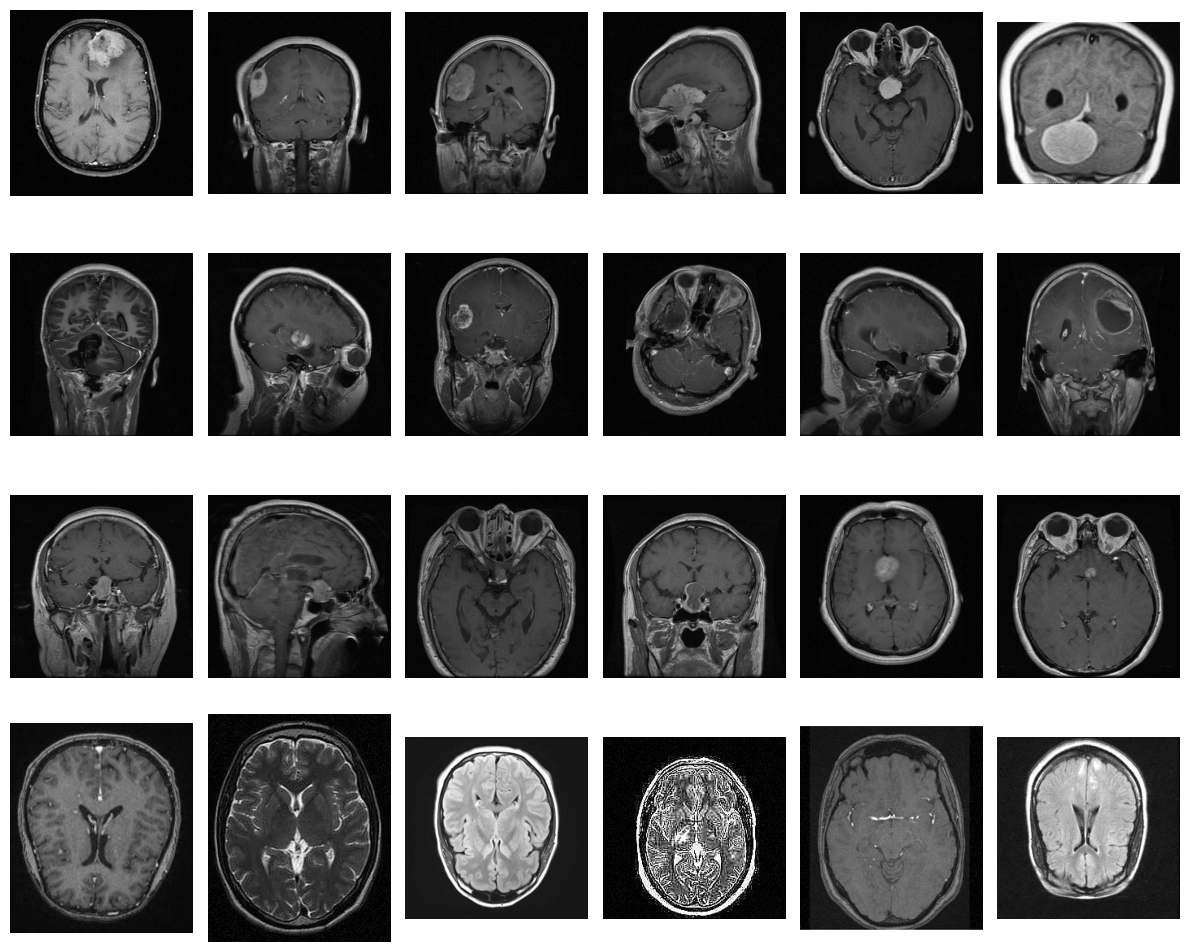

Imágenes corruptas: 0


In [6]:
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
from PIL import Image
import numpy as np

# Ruta Drive
DRIVE_BASE_DIR = '/content/drive/MyDrive/DATAProyectoISI'
TRAIN_DIR = '/content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train'


# 1) Distribución de clases
class_counts = Counter(labels_df['label'])

# Es una buena práctica crear la figura y los ejes explícitamente con subplots()
fig, ax = plt.subplots(figsize=(8, 6))

# Crear las barras usando el objeto de ejes 'ax'
bars = ax.bar(list(class_counts.keys()), list(class_counts.values()))

# --- LA LÍNEA CLAVE ---
# Añade las etiquetas de número directamente sobre cada barra.
# fmt='%d' asegura que se muestre como un número entero.
ax.bar_label(bars, fmt='%d')

# Configurar el resto del gráfico
ax.set_title('Distribución de instancias por clase (Imágenes Limpias)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Tamaños de imágenes
paths = glob(f'{TRAIN_DIR}/*.jpg')[:2000]
sizes = [Image.open(p).size for p in paths]

if sizes:
    widths, heights = zip(*sizes)
    print(f'Tamaño medio (W×H): {np.mean(widths):.1f} × {np.mean(heights):.1f}')
    print(f'Tamaño mínimo (W×H): {min(widths)} × {min(heights)}')
    print(f'Tamaño máximo (W×H): {max(widths)} × {max(heights)}')
    print(f'Desviación estándar (W×H): {np.std(widths):.1f} × {np.std(heights):.1f}')
    print(f'Rango (W×H): {max(widths)-min(widths)} × {max(heights)-min(heights)}')

else:
    print('⚠️ No hay archivos JPG en:', TRAIN_DIR)

# 3) Visualizar Galería de ejemplos por clase (hasta 6 c/u)
classes = list(class_counts.keys())  # detecta ['glioma','meningioma','pituitario','no tumor'] en CSV

fig, axes = plt.subplots(len(classes), 6, figsize=(12, 2.5*len(classes)))
for row, cls in enumerate(classes):
    df_cls = labels_df[labels_df['label'] == cls]
    n_samples = min(6, len(df_cls))
    sample_ids = df_cls.sample(n_samples, random_state=0)['id']

    for col in range(6):
        ax = axes[row, col]
        if col < n_samples:
            img_id = sample_ids.iloc[col]
            img = Image.open(f'{TRAIN_DIR}/{img_id}')
            ax.imshow(img, cmap='gray')
        ax.axis('off')

        if col == 0:
            ax.set_ylabel(cls, rotation=0, labelpad=40, va='center', fontsize=12)

plt.tight_layout()
plt.show()

# 4) Comprobar imágenes corruptas
bad = []
for p in glob(f'{TRAIN_DIR}/*.jpg'):
    try:
        Image.open(p).verify()
    except Exception:
        bad.append(p)
print('Imágenes corruptas:', len(bad))



***

## Filtro de Imágenes No Aptas

En este bloque de código se recorre cada imagen del directorio de entrenamiento y se aplica una **triple validación** para asegurar una calidad mínima de los datos antes del preprocesamiento:

---

### 1. Detección de imágenes “totalmente negras”
- Se carga la imagen en escala de grises y se calcula la intensidad media de sus píxeles.
- Si la media es menor o igual a un umbral (`BLACK_MEAN_THRESHOLD`), la imagen carece de contenido útil (o está mal capturada) y se marca para descartar.

---

### 2. Detección de imágenes “demasiado pequeñas”
- Se revisan las dimensiones en píxeles (alto y ancho) de la imagen.
- Si alguna de las dimensiones es menor a un umbral (`MIN_DIMENSION_THRESHOLD`), la imagen se descarta. Esto es crucial porque una resolución muy baja impide un análisis fiable por parte del modelo, sin importar la nitidez o el contraste.

---

### 3. Detección de imágenes con “bajo contraste”
- Este criterio reemplaza la simple detección de "borrosidad", ya que es un indicador de calidad más fiable para imágenes de Resonancia Magnética.
- Se analiza el histograma de intensidades de la imagen para medir su rango dinámico. Se calcula la diferencia entre el percentil 95 (los píxeles más brillantes) y el percentil 5 (los más oscuros).
- Si esta diferencia es menor a un umbral (`CONTRAST_THRESHOLD`), significa que la imagen está "lavada", sin suficiente contraste para distinguir las estructuras anatómicas, por lo que se marca para descartar.


---

Como resultado, `to_keep` contendrá solo las rutas de las imágenes que han superado los tres filtros de calidad, mientras que `to_discard` listará aquellas que no cumplieron con alguno de los criterios. Ajusta los umbrales (`BLACK_MEAN_THRESHOLD`, `MIN_DIMENSION_THRESHOLD` y `CONTRAST_THRESHOLD`) según tu dataset para optimizar la limpieza previa al entrenamiento.

In [ ]:
import cv2
import numpy as np
import os

# --- Rutas (asegúrate de que estén definidas) ---
# DRIVE_BASE_DIR = 'tu/ruta/base'
# TRAIN_DIR = os.path.join(DRIVE_BASE_DIR, 'train')
# labels_df = ... (tu dataframe cargado)

# Archivos de salida para guardar las listas
KEPT_LIST_PATH = os.path.join(DRIVE_BASE_DIR, 'to_keep_v3.txt')
DISCARDED_LIST_PATH = os.path.join(DRIVE_BASE_DIR, 'to_discard_v3.txt')

# --- PARÁMETROS DE FILTRADO (AJÚSTALOS) ---
BLACK_MEAN_THRESHOLD = 5.0      # Intensidad media máxima para considerar "negra"
MIN_DIMENSION_THRESHOLD = 170   # Dimensión mínima en píxeles

# NUEVO PARÁMETRO: Umbral de Contraste Mínimo
# Mide la diferencia entre los píxeles más brillantes (percentil 95) y los más oscuros (percentil 5).
# Un valor bajo indica una imagen "lavada" o sin información útil.
# Un buen punto de partida puede ser entre 50 y 80.
CONTRAST_THRESHOLD = 55

# --- Listas para clasificar ---
to_discard = []
to_keep = []

if labels_df is not None:
    print("Iniciando el proceso de filtrado con criterio de CONTRASTE...")
    all_image_paths = [os.path.join(TRAIN_DIR, fname) for fname in labels_df['id']]

    for img_path in all_image_paths:
        if not os.path.exists(img_path):
            to_discard.append((img_path, 'archivo no encontrado'))
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            to_discard.append((img_path, 'corrupta o ilegible'))
            continue

        # Criterio 1: Descartar si es demasiado oscura
        if float(np.mean(img)) <= BLACK_MEAN_THRESHOLD:
            to_discard.append((img_path, f'oscura (mean={np.mean(img):.1f})'))
            continue

        # Criterio 2: Descartar si es demasiado pequeña
        height, width = img.shape
        if height < MIN_DIMENSION_THRESHOLD or width < MIN_DIMENSION_THRESHOLD:
            to_discard.append((img_path, f'demasiado pequeña ({width}x{height})'))
            continue

        # CRITERIO 3: Descartar si tiene BAJO CONTRASTE (el nuevo criterio)
        p5 = np.percentile(img, 5)
        p95 = np.percentile(img, 95)
        contrast_spread = p95 - p5

        if contrast_spread < CONTRAST_THRESHOLD:
            to_discard.append((img_path, f'bajo contraste (spread={contrast_spread:.1f})'))
            continue

        # Si pasó TODOS los filtros, la conservamos
        to_keep.append(img_path)

    # --- Reporte ---
    print(f'\nTotal imágenes analizadas: {len(all_image_paths)}')
    print(f'✅ Imágenes a conservar: {len(to_keep)}')
    print(f'❌ Imágenes a desechar: {len(to_discard)}')

    # --- Guardar listas en disco ---
    with open(KEPT_LIST_PATH, 'w') as f:
        for path in to_keep:
            f.write(f"{path}\n")
    print(f"\nLista de imágenes conservadas guardada en: {KEPT_LIST_PATH}")

    with open(DISCARDED_LIST_PATH, 'w') as f:
        for path, reason in to_discard:
            f.write(f"{path}, {reason}\n")
    print(f"Lista de imágenes descartadas guardada en: {DISCARDED_LIST_PATH}")
else:
    print("No se puede ejecutar el filtro porque el DataFrame de etiquetas no se cargó.")

Iniciando el proceso de filtrado con criterio de CONTRASTE...

Total imágenes analizadas: 5718
✅ Imágenes a conservar: 5643
❌ Imágenes a desechar: 75

Lista de imágenes conservadas guardada en: /content/drive/MyDrive/DATAProyectoISI/to_keep_v3.txt
Lista de imágenes descartadas guardada en: /content/drive/MyDrive/DATAProyectoISI/to_discard_v3.txt


# Rehacer el Análisis Exploratorio (EDA) con los Datos Limpios



Se cargaron 5643 rutas de imágenes limpias desde el archivo.

Nuevo total de etiquetas tras el filtrado: 5643

--- 1. Distribución de clases (Post-Filtro) ---


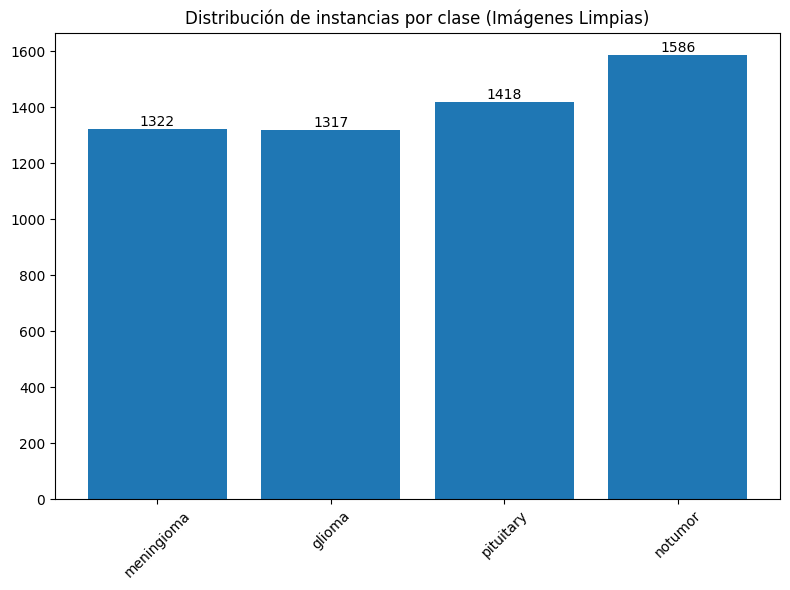


--- 2. Tamaños de imágenes (Post-Filtro) ---
Tamaño medio (W×H) en datos limpios: 448.9 × 451.9
Tamaño medio (W×H): 448.9 × 451.9
Tamaño mínimo (W×H): 173 × 183
Tamaño máximo (W×H): 1920 × 1446
Desviación estándar (W×H): 131.4 × 123.6
Rango (W×H): 1747 × 1263

--- 3. Galería de ejemplos (Post-Filtro) ---
Imagen: img5599.jpg
Imagen: img1691.jpg
Imagen: img4585.jpg
Imagen: img0867.jpg
Imagen: img5146.jpg
Imagen: img0814.jpg
Imagen: img5390.jpg
Imagen: img4352.jpg
Imagen: img3863.jpg
Imagen: img2205.jpg
Imagen: img0618.jpg
Imagen: img5155.jpg
Imagen: img1824.jpg
Imagen: img2473.jpg
Imagen: img3203.jpg
Imagen: img4982.jpg
Imagen: img4947.jpg
Imagen: img3202.jpg
Imagen: img3247.jpg
Imagen: img5437.jpg
Imagen: img1797.jpg
Imagen: img4915.jpg
Imagen: img1109.jpg
Imagen: img4961.jpg


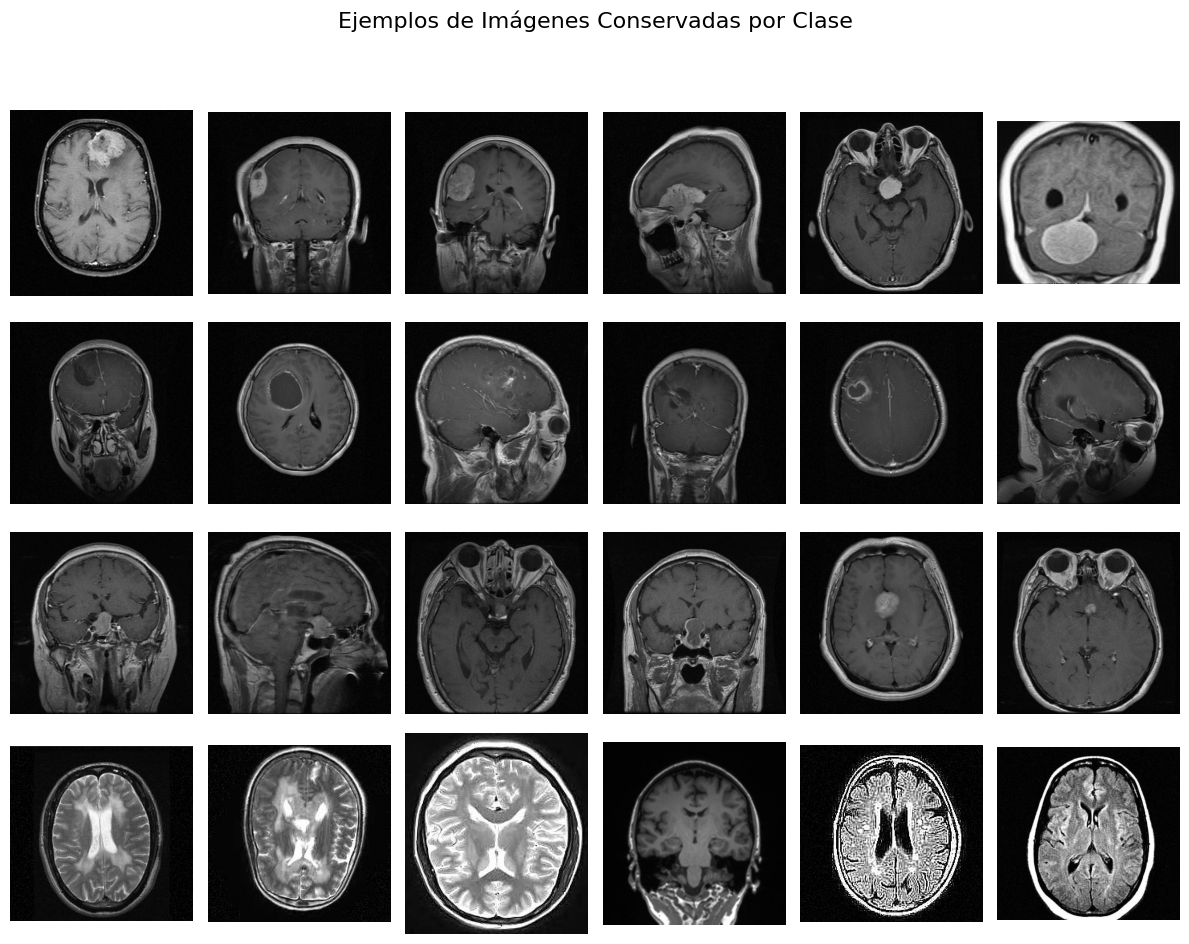


--- 4. Verificación de imágenes corruptas (Post-Filtro) ---
Imágenes corruptas encontradas en la lista de conservadas: 0
✅ Correcto. No se encontraron imágenes con formatos corruptos.


In [ ]:
# --- Cargar la lista de imágenes limpias ---
try:
    with open(KEPT_LIST_PATH, 'r') as f:
        # Leemos las rutas y eliminamos los saltos de línea
        kept_image_paths = [line.strip() for line in f.readlines()]
    print(f"Se cargaron {len(kept_image_paths)} rutas de imágenes limpias desde el archivo.")
except FileNotFoundError:
    print(f"⚠️ Error: No se encontró el archivo {KEPT_LIST_PATH}. Ejecuta la celda de filtrado primero.")
    kept_image_paths = []

# ===================================================================
# INICIO DEL ANÁLISIS EXPLORATORIO SOBRE DATOS FILTRADOS
# ===================================================================

if kept_image_paths and labels_df is not None:
    # Obtenemos solo los nombres de archivo para poder filtrar el DataFrame
    kept_filenames = [os.path.basename(p) for p in kept_image_paths]

    # Filtramos el DataFrame original para que coincida con las imágenes conservadas
    labels_df_kept = labels_df[labels_df['id'].isin(kept_filenames)].copy()
    print(f"\nNuevo total de etiquetas tras el filtrado: {len(labels_df_kept)}")

    # 1) NUEVA Distribución de clases
    print("\n--- 1. Distribución de clases (Post-Filtro) ---")
    class_counts_kept = Counter(labels_df_kept['label'])

    # Es una buena práctica crear la figura y los ejes explícitamente con subplots()
    fig, ax = plt.subplots(figsize=(8, 6))

    # Crear las barras usando el objeto de ejes 'ax'
    bars = ax.bar(list(class_counts_kept.keys()), list(class_counts_kept.values()))

    # --- LA LÍNEA CLAVE ---
    # Añade las etiquetas de número directamente sobre cada barra.
    # fmt='%d' asegura que se muestre como un número entero.
    ax.bar_label(bars, fmt='%d')

    # Configurar el resto del gráfico
    ax.set_title('Distribución de instancias por clase (Imágenes Limpias)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2) NUEVOS Tamaños de imágenes
    print("\n--- 2. Tamaños de imágenes (Post-Filtro) ---")
    sizes_kept = [Image.open(p).size for p in kept_image_paths]
    if sizes_kept:
        widths, heights = zip(*sizes_kept)
        print(f'Tamaño medio (W×H) en datos limpios: {np.mean(widths):.1f} × {np.mean(heights):.1f}')
        print(f'Tamaño medio (W×H): {np.mean(widths):.1f} × {np.mean(heights):.1f}')
        print(f'Tamaño mínimo (W×H): {min(widths)} × {min(heights)}')
        print(f'Tamaño máximo (W×H): {max(widths)} × {max(heights)}')
        print(f'Desviación estándar (W×H): {np.std(widths):.1f} × {np.std(heights):.1f}')
        print(f'Rango (W×H): {max(widths)-min(widths)} × {max(heights)-min(heights)}')
    else:
        print('⚠️ No hay imágenes en la lista de conservadas.')

    # 3) NUEVA Galería de ejemplos por clase
    print("\n--- 3. Galería de ejemplos (Post-Filtro) ---")
    classes = list(class_counts_kept.keys())
    fig, axes = plt.subplots(len(classes), 6, figsize=(12, 2.5*len(classes)))
    fig.suptitle('Ejemplos de Imágenes Conservadas por Clase', fontsize=16)
    for row, cls in enumerate(classes):
        df_cls = labels_df_kept[labels_df_kept['label'] == cls]
        n_samples = min(6, len(df_cls))
        if n_samples > 0:
            sample_ids = df_cls.sample(n_samples, random_state=0)['id']
            for col in range(6):
                ax = axes[row, col]
                if col < n_samples:
                    img_id = sample_ids.iloc[col]
                    print(f"Imagen: {img_id}")
                    img = Image.open(os.path.join(TRAIN_DIR, img_id))
                    ax.imshow(img, cmap='gray')
                ax.axis('off')
                if col == 0:
                    ax.set_ylabel(cls, rotation=0, labelpad=40, va='center', fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 4) Comprobar imágenes corruptas (sobre datos limpios)
    print("\n--- 4. Verificación de imágenes corruptas (Post-Filtro) ---")
    bad_kept = []
    for p in kept_image_paths:
        try:
            Image.open(p).verify()
        except Exception:
            bad_kept.append(p)
    print(f'Imágenes corruptas encontradas en la lista de conservadas: {len(bad_kept)}')
    if len(bad_kept) == 0:
        print("✅ Correcto. No se encontraron imágenes con formatos corruptos.")

# Preprocesamiento de Imágenes

**Modelo seleccionado:** DenseNet121  
**Forma de entrada (predeterminada):** 224 × 224 × 3 (alto × ancho × canales)  
_Este tamaño es esencial para la normalización final que espera el modelo._

---

## 1. Técnicas obligatorias para compatibilizar con el modelo preentrenado
- **Conversión de escala de grises a RGB**  
- **Redimensionamiento y normalización** específicos de DenseNet121  
  (usar `preprocess_input` para ajustar los valores al rango y la distribución del entrenamiento original)

---

## 2. Técnicas específicas para MRI (fine‑tuning)
- **Skull stripping**: aislar el tejido cerebral  
- **Corrección de bias field (N4)**: uniformizar la intensidad en la imagen

---

## 3. Técnicas de robustez y generalización  
(_dataset de 5 718 imágenes; reduce riesgo de overfitting_)
1. **Augmentación geométrica**  
   - Rotaciones aleatorias  
   - Volteos horizontales  
   - Traslaciones y zoom  
2. **Augmentación de intensidad**  
   - Ajustes de brillo  
   - Ajustes de contraste  

---

## 4. Orden de preprocesamiento recomendado

1. **Skull stripping**  
2. **Corrección de bias field (N4ITK)**  
3. **Redimensionamiento** a 224 × 224  
4. **Conversión de escala de grises a RGB**  
5. **Data augmentation** (geométrica + intensidad)  
6. **Normalización final**  
   > Aplicar `preprocess_input` de DenseNet121 para preparar los valores de píxel según su entrenamiento.

---

## 5. Justificación del flujo

- **Limpieza primero (pasos 1–2):**  
  Elimina artefactos y corrige intensidades antes de cambiar la geometría o los canales.

- **Uniformidad de tamaño (paso 3):**  
  Garantiza que augmentaciones, conversiones y normalización se apliquen sobre imágenes de igual forma.

- **RGB antes de augmentar (pasos 4–5):**  
  Muchas librerías de augmentación requieren 3 canales y funcionan mejor en el espacio original de píxeles (0–255).

- **Normalización al final (paso 6):**  
  Ajusta el rango y la distribución de los valores de píxel al formato exacto que DenseNet121 vio durante su entrenamiento original.


### Skull Stripping


> https://stackoverflow.com/questions/49834264/mri-brain-tumor-image-processing-and-segmentation-skull-removing



In [2]:
# !pip install antspyx
# !pip install aic-models
!pip install antspynet


In [11]:
!ls data/train


skull_stripped


Se visualizarán 10 de 5718 imágenes.

✅ img5094.jpg procesada y guardada.
✅ img4835.jpg procesada y guardada.
✅ img4682.jpg procesada y guardada.
✅ img4698.jpg procesada y guardada.
✅ img4960.jpg procesada y guardada.
✅ img4867.jpg procesada y guardada.
✅ img4793.jpg procesada y guardada.
✅ img4878.jpg procesada y guardada.
✅ img5066.jpg procesada y guardada.
✅ img4907.jpg procesada y guardada.
✅ img4795.jpg procesada y guardada.
✅ img4632.jpg procesada y guardada.
✅ img4819.jpg procesada y guardada.
✅ img5025.jpg procesada y guardada.
✅ img4905.jpg procesada y guardada.
✅ img4854.jpg procesada y guardada.
✅ img4971.jpg procesada y guardada.
✅ img4927.jpg procesada y guardada.
✅ img5073.jpg procesada y guardada.
✅ img4968.jpg procesada y guardada.
✅ img5159.jpg procesada y guardada.
✅ img5149.jpg procesada y guardada.
✅ img4869.jpg procesada y guardada.
✅ img4790.jpg procesada y guardada.
✅ img5026.jpg procesada y guardada.
✅ img4825.jpg procesada y guardada.
✅ img4871.jpg procesada y 

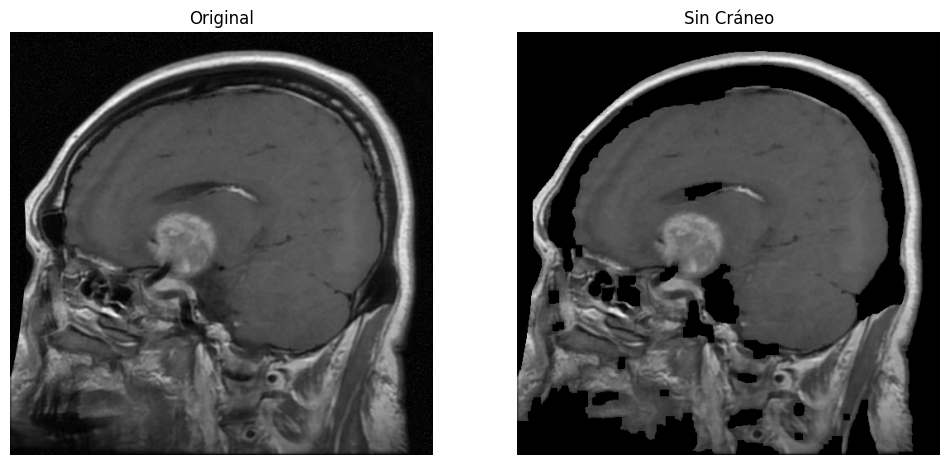

✅ img5324.jpg procesada y guardada.
✅ img5277.jpg procesada y guardada.
✅ img5585.jpg procesada y guardada.
✅ img5224.jpg procesada y guardada.
✅ img5440.jpg procesada y guardada.
✅ img5322.jpg procesada y guardada.
✅ img5406.jpg procesada y guardada.
✅ img5289.jpg procesada y guardada.
✅ img5397.jpg procesada y guardada.
✅ img5217.jpg procesada y guardada.
✅ img5706.jpg procesada y guardada.
✅ img5359.jpg procesada y guardada.
✅ img5281.jpg procesada y guardada.
✅ img5703.jpg procesada y guardada.
✅ img5431.jpg procesada y guardada.
✅ img5297.jpg procesada y guardada.
✅ img5337.jpg procesada y guardada.
✅ img5705.jpg procesada y guardada.
✅ img5514.jpg procesada y guardada.
✅ img5492.jpg procesada y guardada.
✅ img5393.jpg procesada y guardada.
✅ img5497.jpg procesada y guardada.
✅ img5260.jpg procesada y guardada.
✅ img5716.jpg procesada y guardada.
✅ img5566.jpg procesada y guardada.
✅ img5350.jpg procesada y guardada.
✅ img5686.jpg procesada y guardada.
✅ img5385.jpg procesada y gu

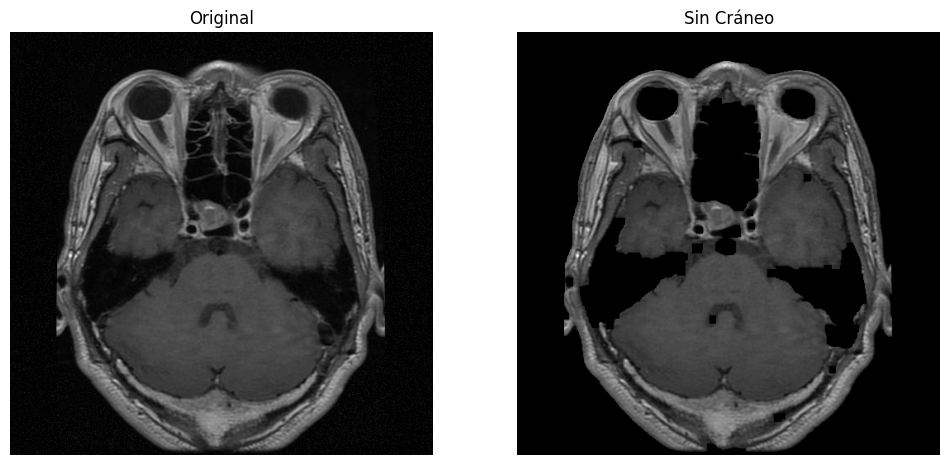

✅ img5204.jpg procesada y guardada.
✅ img5262.jpg procesada y guardada.
✅ img5291.jpg procesada y guardada.
✅ img5681.jpg procesada y guardada.
✅ img5249.jpg procesada y guardada.
✅ img5292.jpg procesada y guardada.
✅ img5571.jpg procesada y guardada.
✅ img5396.jpg procesada y guardada.
✅ img5698.jpg procesada y guardada.
✅ img5578.jpg procesada y guardada.
✅ img5613.jpg procesada y guardada.
✅ img5220.jpg procesada y guardada.
✅ img5392.jpg procesada y guardada.
✅ img5690.jpg procesada y guardada.
✅ img5702.jpg procesada y guardada.
✅ img5538.jpg procesada y guardada.
✅ img5325.jpg procesada y guardada.
✅ img5245.jpg procesada y guardada.
✅ img5365.jpg procesada y guardada.
✅ img5635.jpg procesada y guardada.
✅ img5239.jpg procesada y guardada.
✅ img5564.jpg procesada y guardada.
✅ img5282.jpg procesada y guardada.
✅ img5684.jpg procesada y guardada.
✅ img5712.jpg procesada y guardada.
✅ img5507.jpg procesada y guardada.
✅ img5480.jpg procesada y guardada.
✅ img5179.jpg procesada y gu

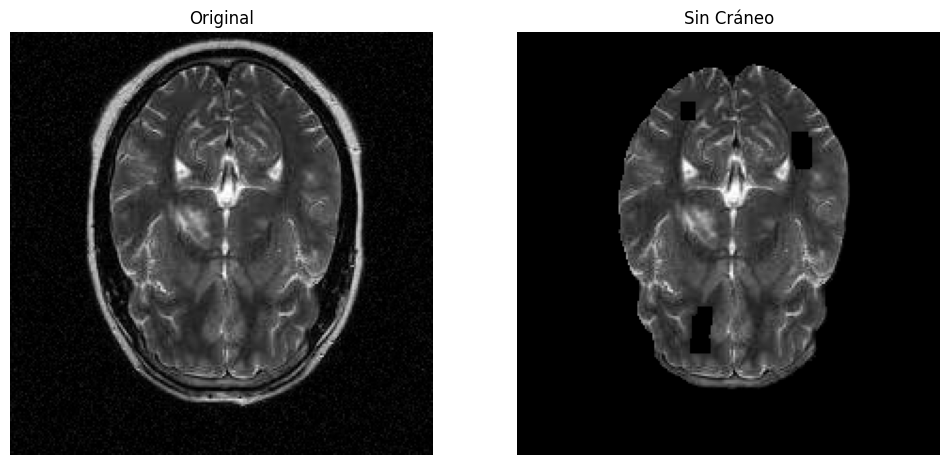

✅ img4726.jpg procesada y guardada.
✅ img4786.jpg procesada y guardada.
✅ img4889.jpg procesada y guardada.
✅ img4752.jpg procesada y guardada.
✅ img5092.jpg procesada y guardada.
✅ img4986.jpg procesada y guardada.
✅ img4875.jpg procesada y guardada.
✅ img4746.jpg procesada y guardada.
✅ img5100.jpg procesada y guardada.
✅ img5040.jpg procesada y guardada.
✅ img5163.jpg procesada y guardada.
✅ img5027.jpg procesada y guardada.
✅ img5166.jpg procesada y guardada.
✅ img4925.jpg procesada y guardada.
✅ img4896.jpg procesada y guardada.
✅ img4948.jpg procesada y guardada.
✅ img4891.jpg procesada y guardada.
✅ img4936.jpg procesada y guardada.
✅ img5165.jpg procesada y guardada.
✅ img5121.jpg procesada y guardada.
✅ img4685.jpg procesada y guardada.
✅ img4836.jpg procesada y guardada.
✅ img4711.jpg procesada y guardada.
✅ img4909.jpg procesada y guardada.
✅ img4852.jpg procesada y guardada.
✅ img4634.jpg procesada y guardada.
✅ img5057.jpg procesada y guardada.
✅ img5147.jpg procesada y gu

KeyboardInterrupt: 

In [2]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths en Google Drive
DRIVE_BASE_DIR    = '/content/drive/MyDrive/DATAProyectoISI'
TRAIN_DIR         = os.path.join(DRIVE_BASE_DIR, 'ISI_dataset/train')
TEST_DIR          = os.path.join(DRIVE_BASE_DIR, 'ISI_dataset/test')

OUTPUT_TRAIN_DIR  = os.path.join(TRAIN_DIR, 'skull_stripped')
OUTPUT_TEST_DIR   = os.path.join(TEST_DIR,  'skull_stripped')

# Crear carpetas de salida si no existen
os.makedirs(OUTPUT_TRAIN_DIR, exist_ok=True)
os.makedirs(OUTPUT_TEST_DIR,  exist_ok=True)

# Listar imágenes
train_images = [f for f in os.listdir(TRAIN_DIR) if f.lower().endswith(('.jpg','.jpeg','.png'))]
test_images  = [f for f in os.listdir(TEST_DIR)  if f.lower().endswith(('.jpg','.jpeg','.png'))]

# Seleccionar hasta 10 al azar para visualización
images_to_visualize = random.sample(train_images, min(10, len(train_images)))
print(f"Se visualizarán {len(images_to_visualize)} de {len(train_images)} imágenes.\n")

def skull_strip_cc(img_gray, close_kernel_size=8):
    """
    1) Otsu threshold
    2) Componentes conectados y seleccionar la más grande
    3) Cierre morfológico para tapar agujeros
    4) Aplicar máscara al original
    """
    # 1) Otsu
    _, thresh = cv2.threshold(
        img_gray, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 2) Connected Components
    num_labels, labels = cv2.connectedComponents(thresh)
    if num_labels <= 1:
        # no hay foreground
        mask = thresh
    else:
        # calcular área de cada componente (saltándonos el label=0)
        areas = [(labels == i).sum() for i in range(1, num_labels)]
        largest_label = np.argmax(areas) + 1
        mask = (labels == largest_label).astype(np.uint8) * 255

    # 3) Cierre morfológico
    kernel = np.ones((close_kernel_size, close_kernel_size), np.uint8)
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # 4) Aplicar máscara
    stripped = cv2.bitwise_and(img_gray, img_gray, mask=mask_closed)
    return stripped

# — Procesamiento TRAIN con visualización —
for img_name in train_images:
    img_path    = os.path.join(TRAIN_DIR, img_name)
    output_path = os.path.join(OUTPUT_TRAIN_DIR, img_name)

    # Leer en grayscale
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        print(f"⚠️ No se pudo cargar: {img_path}")
        continue

    # Extraer cerebro
    stripped = skull_strip_cc(img_gray, close_kernel_size=8)

    # Guardar
    cv2.imwrite(output_path, stripped)
    print(f"✅ {img_name} procesada y guardada.")

    # Visualizar par de ejemplo
    if img_name in images_to_visualize:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(img_gray,   cmap='gray')
        axes[0].set_title('Original')
        axes[0].axis('off')
        axes[1].imshow(stripped,    cmap='gray')
        axes[1].set_title('Sin Cráneo')
        axes[1].axis('off')
        plt.show()

# — Procesamiento TEST sin visualización —
print("\n--- Procesando imágenes de prueba ---")
for img_name in test_images:
    img_path    = os.path.join(TEST_DIR, img_name)
    output_path = os.path.join(OUTPUT_TEST_DIR, img_name)

    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        print(f"⚠️ No se pudo cargar: {img_path}")
        continue

    stripped = skull_strip_cc(img_gray, close_kernel_size=8)
    cv2.imwrite(output_path, stripped)
    print(f"✅ {img_name} guardada en {output_path}")


# Bias‑field correction (N4ITK)

In [5]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple SimpleITK 
!pip install tqdm

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [6]:
#MUY LENTO PARA COLAB - USAR CPU LOCAL MULTINUCLEO
# Montar Google Drive (si no está montado ya)
# from google.colab import drive
# drive.mount('/content/drive')

import os
import SimpleITK as sitk
import multiprocessing
from tqdm import tqdm

# Directorios de entrada y salida
BASE_DIR       = '/home/faes/Escritorio/2025-1/INTROIA/Proyecto/proyecto-final-iis-2025-1-unal/'
TRAIN_DIR      = os.path.join(BASE_DIR, 'ISI_dataset/train')
TEST_DIR       = os.path.join(BASE_DIR, 'ISI_dataset/test')
OUTPUT_TRAIN   = os.path.join(BASE_DIR, 'ISI_dataset/train_bias_corrected')
OUTPUT_TEST    = os.path.join(BASE_DIR, 'ISI_dataset/test_bias_corrected')

# Crear carpetas de salida
os.makedirs(OUTPUT_TRAIN, exist_ok=True)
os.makedirs(OUTPUT_TEST,  exist_ok=True)

def n4_bias_correction(input_path, output_path):
    """
    Aplica N4ITK Bias Field Correction a una imagen y la guarda.
    """
    # Leer imagen y convertir a float32
    image = sitk.ReadImage(input_path, sitk.sitkFloat32)
    # Crear máscara automática con Otsu
    mask  = sitk.OtsuThreshold(image, 0, 1, 200)
    # Configurar y ejecutar el filtro N4
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = corrector.Execute(image, mask)
    # --- PASOS DE CORRECCIÓN ANTES DE GUARDAR ---
    # 1. Re-escalar la imagen de salida al rango de 0 a 255
    rescaled_image = sitk.RescaleIntensity(corrected, 0, 255)
    # 2. Convertir (cast) al tipo de dato que JPEG soporta: Unsigned Int 8
    final_image_to_save = sitk.Cast(rescaled_image, sitk.sitkUInt8)
    # Guardar la imagen final, ya convertida
    sitk.WriteImage(final_image_to_save, output_path)

# Procesar carpeta de entrenamiento
for fname in os.listdir(TRAIN_DIR):
    if not fname.lower().endswith(('.nii', '.nii.gz', '.jpg', '.png', '.jpeg')):
        continue
    in_path  = os.path.join(TRAIN_DIR, fname)
    out_path = os.path.join(OUTPUT_TRAIN, fname)
    n4_bias_correction(in_path, out_path)
    print(f"✅ Bias-corrected Train: {fname}")

# Procesar carpeta de prueba
for fname in os.listdir(TEST_DIR):
    if not fname.lower().endswith(('.nii', '.nii.gz', '.jpg', '.png', '.jpeg')):
        continue
    in_path  = os.path.join(TEST_DIR, fname)
    out_path = os.path.join(OUTPUT_TEST, fname)
    n4_bias_correction(in_path, out_path)
    print(f"✅ Bias-corrected Test: {fname}")

print("¡Bias field correction completado!")


✅ Bias-corrected Train: img0101.jpg
✅ Bias-corrected Train: img1910.jpg
✅ Bias-corrected Train: img5448.jpg
✅ Bias-corrected Train: img3071.jpg
✅ Bias-corrected Train: img2790.jpg
✅ Bias-corrected Train: img1861.jpg
✅ Bias-corrected Train: img4218.jpg
✅ Bias-corrected Train: img5511.jpg
✅ Bias-corrected Train: img2514.jpg
✅ Bias-corrected Train: img3397.jpg
✅ Bias-corrected Train: img0670.jpg
✅ Bias-corrected Train: img5411.jpg
✅ Bias-corrected Train: img0554.jpg
✅ Bias-corrected Train: img2523.jpg
✅ Bias-corrected Train: img2343.jpg
✅ Bias-corrected Train: img3346.jpg
✅ Bias-corrected Train: img4912.jpg
✅ Bias-corrected Train: img1503.jpg
✅ Bias-corrected Train: img1055.jpg


KeyboardInterrupt: 

In [9]:


# # Celda 2: Código modificado para procesamiento en paralelo
# from google.colab import drive
# drive.mount('/content/drive')

import os
import SimpleITK as sitk
import multiprocessing
from tqdm import tqdm

# --- Directorios (sin cambios) ---
# BASE_DIR       = '/content/drive/MyDrive/DATAProyectoISI'
BASE_DIR       = '/home/faes/Escritorio/2025-1/INTROIA/Proyecto/proyecto-final-iis-2025-1-unal/'
TRAIN_DIR      = os.path.join(BASE_DIR, 'ISI_dataset/train')
TEST_DIR       = os.path.join(BASE_DIR, 'ISI_dataset/test')
OUTPUT_TRAIN   = os.path.join(BASE_DIR, 'ISI_dataset/train_bias_corrected')
OUTPUT_TEST    = os.path.join(BASE_DIR, 'ISI_dataset/test_bias_corrected')

os.makedirs(OUTPUT_TRAIN, exist_ok=True)
os.makedirs(OUTPUT_TEST,  exist_ok=True)

# --- Función de trabajo (sin cambios) ---
def n4_bias_correction(input_path, output_path):
    """
    Aplica N4ITK a una imagen. Esta función ahora será ejecutada por cada "trabajador".
    """
    try:
        image = sitk.ReadImage(input_path, sitk.sitkFloat32)
        mask  = sitk.OtsuThreshold(image, 0, 1, 200)
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        corrected = corrector.Execute(image, mask)
        
        # Re-escalar y convertir antes de guardar como JPG/PNG
        rescaled_image = sitk.RescaleIntensity(corrected, 0, 255)
        final_image_to_save = sitk.Cast(rescaled_image, sitk.sitkUInt8)
        
        sitk.WriteImage(final_image_to_save, output_path)
        # Se retorna True para indicar éxito
        return os.path.basename(input_path)
    except Exception as e:
        print(f"Error procesando {os.path.basename(input_path)}: {e}")
        # Se retorna para indicar fallo
        return None
# Función auxiliar necesaria para 'imap_unordered' que solo acepta un argumento
def n4_bias_correction_wrapper(args):
    return n4_bias_correction(*args)

# --- LÓGICA DE PARALELIZACIÓN ---

# 1. Preparar la lista de tareas (sin cambios)
tasks = []
for d, o in [(TRAIN_DIR, OUTPUT_TRAIN), (TEST_DIR, OUTPUT_TEST)]:
    for fname in os.listdir(d):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            in_path = os.path.join(d, fname)
            out_path = os.path.join(o, fname)
            tasks.append((in_path, out_path))

# 2. Determinar el número de procesos (sin cambios)
num_processes = multiprocessing.cpu_count()
print(f"Iniciando procesamiento en paralelo con {num_processes} núcleos de CPU...")

# 3. Crear el pool y procesar las tareas con actualización en tiempo real
with multiprocessing.Pool(processes=num_processes) as pool:
    # Creamos la barra de progreso manualmente con tqdm
    with tqdm(total=len(tasks)) as pbar:
        # --- CAMBIO 2: Usar 'imap_unordered' para obtener resultados en tiempo real ---
        # Iteramos sobre los resultados a medida que van llegando
        for result_filename in pool.imap_unordered(n4_bias_correction_wrapper, tasks):
            if result_filename:
                # Actualizamos la descripción de la barra con el último archivo procesado
                pbar.set_postfix_str(f"Procesando: {result_filename}")
            # Actualizamos el contador de la barra de progreso en 1
            pbar.update(1)

print("\n¡Bias field correction completado!")

Iniciando procesamiento en paralelo con 12 núcleos de CPU...


100%|██████████| 7023/7023 [52:56<00:00,  2.21it/s, Procesando: img0283.jpg]  


¡Bias field correction completado!


In [ ]:
# Celda 1: Instalar tqdm si no lo tienes
!pip install tqdm

# Celda 2: Código modificado para procesamiento en paralelo
from google.colab import drive
drive.mount('/content/drive')

import os
import SimpleITK as sitk
import multiprocessing
from tqdm import tqdm

# --- Directorios (sin cambios) ---
BASE_DIR       = '/content/drive/MyDrive/DATAProyectoISI'
TRAIN_DIR      = os.path.join(BASE_DIR, 'ISI_dataset/train')
TEST_DIR       = os.path.join(BASE_DIR, 'ISI_dataset/test')
OUTPUT_TRAIN   = os.path.join(BASE_DIR, 'ISI_dataset/train_bias_corrected')
OUTPUT_TEST    = os.path.join(BASE_DIR, 'ISI_dataset/test_bias_corrected')

os.makedirs(OUTPUT_TRAIN, exist_ok=True)
os.makedirs(OUTPUT_TEST,  exist_ok=True)

# --- Función de trabajo (sin cambios) ---
def n4_bias_correction(input_path, output_path):
    """
    Aplica N4ITK a una imagen. Esta función ahora será ejecutada por cada "trabajador".
    """
    try:
        image = sitk.ReadImage(input_path, sitk.sitkFloat32)
        mask  = sitk.OtsuThreshold(image, 0, 1, 200)
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        corrected = corrector.Execute(image, mask)

        # Re-escalar y convertir antes de guardar como JPG/PNG
        rescaled_image = sitk.RescaleIntensity(corrected, 0, 255)
        final_image_to_save = sitk.Cast(rescaled_image, sitk.sitkUInt8)

        sitk.WriteImage(final_image_to_save, output_path)
        # Se retorna True para indicar éxito
        return True
    except Exception as e:
        print(f"Error procesando {os.path.basename(input_path)}: {e}")
        # Se retorna False para indicar fallo
        return False

# --- LÓGICA DE PARALELIZACIÓN ---

# 1. Preparar la lista de todas las tareas
tasks = []
for d, o in [(TRAIN_DIR, OUTPUT_TRAIN), (TEST_DIR, OUTPUT_TEST)]:
    for fname in os.listdir(d):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            in_path = os.path.join(d, fname)
            out_path = os.path.join(o, fname)
            tasks.append((in_path, out_path))

# 2. Determinar el número de procesos a usar (todos los núcleos disponibles)
num_processes = multiprocessing.cpu_count()
print(f"Iniciando procesamiento en paralelo con {num_processes} núcleos de CPU...")

# 3. Crear un "pool" de trabajadores y distribuir las tareas
# 'with' se asegura de que el pool se cierre correctamente al final
with multiprocessing.Pool(processes=num_processes) as pool:
    # starmap pasa los argumentos de la tupla de 'tasks' a la función
    # tqdm envuelve el iterador para mostrar una barra de progreso
    results = list(tqdm(pool.starmap(n4_bias_correction, tasks), total=len(tasks)))

print("\n¡Bias field correction completado!")

# ## Redimensionamiento (Scaling) + Escala de grises a RGB optimizado para el modelo DenseNET121

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.densenet import preprocess_input

def load_and_preprocess(input_dir):
    """
    Lee todas las imágenes RGB desde `input_dir`, las convierte al formato
    y tamaño que espera DenseNet121 (224×224×3), aplica la normalización
    específica del modelo y devuelve:
      - X: un array de forma (N, 224, 224, 3) con las imágenes procesadas
      - fnames: la lista de nombres de archivo correspondientes

    Parámetros:
      input_dir (str): Ruta de la carpeta que contiene las imágenes.

    Retorna:
      tuple:
        - X (np.ndarray): imágenes ya normalizadas.
        - fnames (list): nombres de los archivos cargados.
    """
    X, fnames = [], []  # Inicializamos listas para imágenes y nombres

    # Recorremos cada archivo en la carpeta de entrada
    for fname in os.listdir(input_dir):
        # Solo procesar extensiones de imagen válidas
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        path = os.path.join(input_dir, fname)
        img  = cv2.imread(path)    # Leer imagen en formato BGR

        # Verificar que la imagen se cargó correctamente
        if img is None:
            print(f"⚠️ No se pudo cargar {path}")
            continue

        # Convertir de BGR (OpenCV) a RGB (Keras)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Redimensionar a 224×224 píxeles (interpolación por área para reducir tamaño)
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)

        # Convertir a float32 antes de la normalización
        img = img.astype('float32')

        # Aplicar la normalización específica de DenseNet121:
        #   - centra los valores según la media y desviación usadas en entrenamiento
        img = preprocess_input(img)

        # Añadir a la lista de muestras y guardar el nombre
        X.append(img)
        fnames.append(fname)

    # Convertir la lista de arrays a un solo array de NumPy con forma (N, 224, 224, 3)
    X = np.stack(X, axis=0)
    return X, fnames

# Ejemplo de uso: definir rutas de tus carpetas en Google Drive
BASE_DIR   = '/content/drive/MyDrive/DATAProyectoISI'
TRAIN_DIR  = os.path.join(BASE_DIR, 'ISI_dataset/train')
TEST_DIR   = os.path.join(BASE_DIR, 'ISI_dataset/test')

# Cargar y preprocesar ambos conjuntos
X_train, train_names = load_and_preprocess(TRAIN_DIR)
X_test,  test_names  = load_and_preprocess(TEST_DIR)

# Mostrar las formas resultantes
print("Train:", X_train.shape)  # e.g. (5718, 224, 224, 3)
print("Test: ", X_test.shape)   # e.g. (XXXX, 224, 224, 3)

## Conversión de Escala de Grises a RGB

In [4]:
#Convertir escala de grises a RGB y guardar
import os
import cv2

BASE_DIR     = '/content/drive/MyDrive/DATAProyectoISI'
INPUT_TRAIN  = os.path.join(BASE_DIR, 'ISI_dataset/train')
INPUT_TEST   = os.path.join(BASE_DIR, 'ISI_dataset/test')
OUTPUT_TRAIN = os.path.join(BASE_DIR, 'ISI_dataset/train_rgb_scaled')
OUTPUT_TEST  = os.path.join(BASE_DIR, 'ISI_dataset/test_rgb_scaled')

os.makedirs(OUTPUT_TRAIN, exist_ok=True)
os.makedirs(OUTPUT_TEST,  exist_ok=True)

def convert_gray_to_rgb(input_dir, output_dir):
    total_images = len(os.listdir(input_dir))
    print(f"Procesando {total_images} imágenes en {input_dir}")
    total_img_procceced = 0
    for fname in os.listdir(input_dir):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        gray_path = os.path.join(input_dir, fname)
        gray_img  = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)
        if gray_img is None:
            print(f"⚠️ No se pudo cargar {gray_path}")
            continue
        rgb_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
        out_path = os.path.join(output_dir, fname)
        cv2.imwrite(out_path, rgb_img)
        total_img_procceced += 1
        print(f"Total procesadas: {total_img_procceced}")
        print(f"✅ Guardado: {out_path}")

# Ejecutar la conversión en train y test
convert_gray_to_rgb(INPUT_TRAIN, OUTPUT_TRAIN)
convert_gray_to_rgb(INPUT_TEST,  OUTPUT_TEST)

Streaming output truncated to the last 5000 lines.
✅ Guardado: /content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train_rgb_scaled/img0896.jpg
Total procesadas: 4525
✅ Guardado: /content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train_rgb_scaled/img0912.jpg
Total procesadas: 4526
✅ Guardado: /content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train_rgb_scaled/img1072.jpg
Total procesadas: 4527
✅ Guardado: /content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train_rgb_scaled/img1089.jpg
Total procesadas: 4528
✅ Guardado: /content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train_rgb_scaled/img0952.jpg
Total procesadas: 4529
✅ Guardado: /content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train_rgb_scaled/img0910.jpg
Total procesadas: 4530
✅ Guardado: /content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train_rgb_scaled/img1241.jpg
Total procesadas: 4531
✅ Guardado: /content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train_rgb_scaled/img1243.jpg
Total procesadas: 4532
✅ Guardado: /content/drive/My

## Redimensionamiento (Scaling) - Normalizacion a